In [ ]:
# Install libraries
!pip install numpy pandas matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Setting up the aesthetics for plots
sns.set(style="whitegrid")


In [ ]:
import tensorflow_datasets as tfds

# Load the dataset
ds, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Get train and test datasets
train_dataset, test_dataset = ds['train'], ds['test']

# Convert TensorFlow datasets to Pandas DataFrames for easier manipulation
train_data = tfds.as_dataframe(train_dataset, info)
test_data = tfds.as_dataframe(test_dataset, info)

# Decode bytes to string and simplify the labels (positive and negative)
train_data['text'] = train_data['text'].apply(lambda x: x.decode('utf-8'))
train_data['label'] = train_data['label'].map({0: 'negative', 1: 'positive'})

test_data['text'] = test_data['text'].apply(lambda x: x.decode('utf-8'))
test_data['label'] = test_data['label'].map({0: 'negative', 1: 'positive'})


In [ ]:
# Basic info
print(train_data.head())
print("Training Set Shape:", train_data.shape)
print("Test Set Shape:", test_data.shape)

# Check for class distribution
print(train_data['label'].value_counts())
print(test_data['label'].value_counts())

# Check for any null values
print(train_data.isnull().sum())
print(test_data.isnull().sum())


      label                                               text
0  negative  This was an absolutely terrible movie. Don't b...
1  negative  I have been known to fall asleep during films,...
2  negative  Mann photographs the Alberta Rocky Mountains i...
3  positive  This is the kind of film for a snowy Sunday af...
4  positive  As others have mentioned, all the women that g...
Training Set Shape: (25000, 2)
Test Set Shape: (25000, 2)
label
negative    12500
positive    12500
Name: count, dtype: int64
label
positive    12500
negative    12500
Name: count, dtype: int64
label    0
text     0
dtype: int64
label    0
text     0
dtype: int64


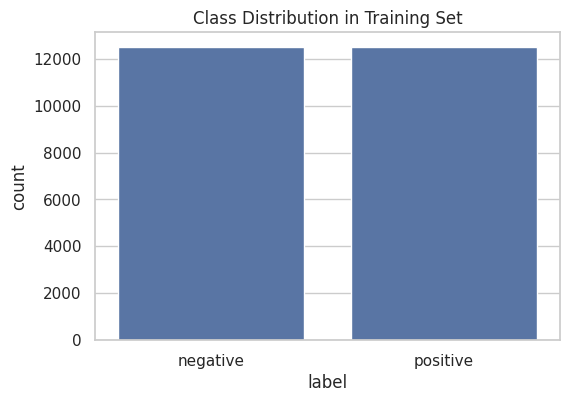

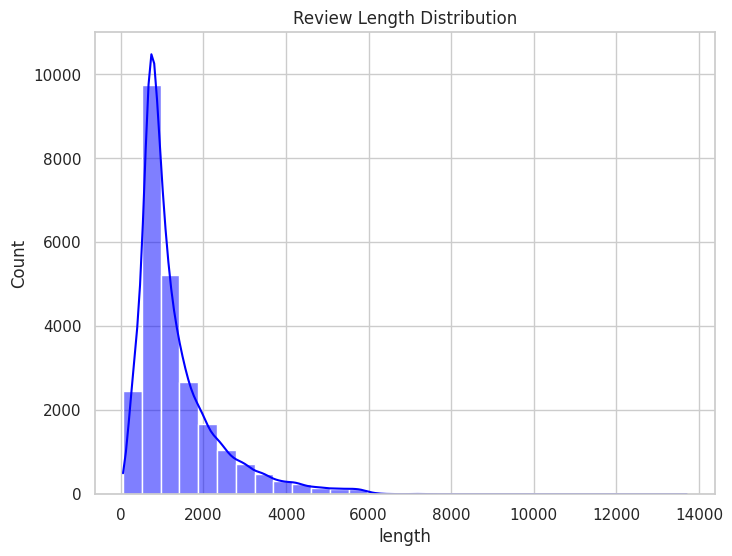

In [ ]:
# Visualizing the distribution of classes
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_data)
plt.title('Class Distribution in Training Set')
plt.show()

# Plotting length of reviews
train_data['length'] = train_data['text'].apply(len)
plt.figure(figsize=(8,6))
sns.histplot(train_data['length'], bins=30, kde=True, color='blue')
plt.title('Review Length Distribution')
plt.show()


In [ ]:
# Identify very short reviews which might not be useful
short_reviews = train_data[train_data['length'] < 50]
print("Number of unusually short reviews:", len(short_reviews))

# Example of a few short reviews
print(short_reviews.head())

# Finding any empty or extremely short reviews
empty_or_short = train_data[train_data['text'].str.strip().apply(len) < 10]
print("Empty or Extremely Short Reviews:", empty_or_short.shape[0])


Number of unusually short reviews: 0
Empty DataFrame
Columns: [label, text, length]
Index: []
Empty or Extremely Short Reviews: 0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      Word  Frequency
0    /><br      50935
1    movie      30506
2     film      27402
3      one      20692
4     like      18133
5    would      11923
6     good      11436
7   really      10815
8     even      10607
9      see      10155
10       -       9355
11     get       8777
12   story       8527
13    much       8507
14    time       7765
15    make       7485
16   could       7462
17    also       7422
18   first       7339
19  people       7335


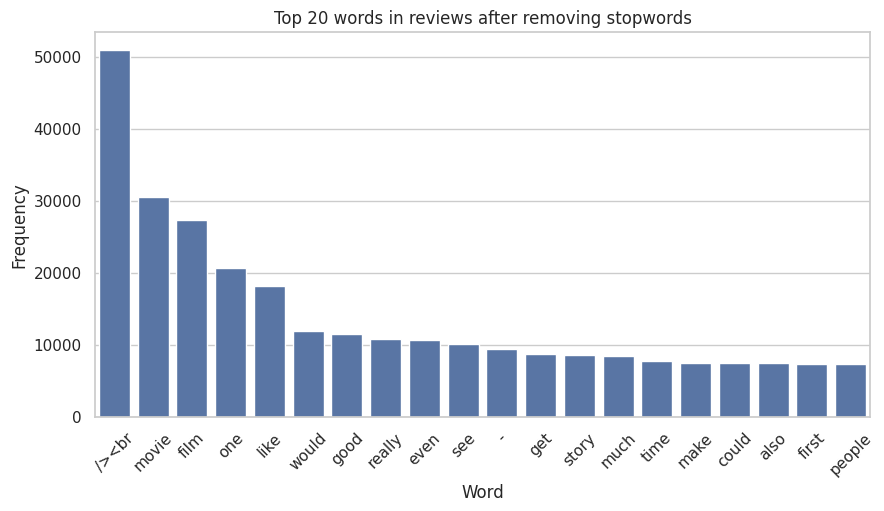

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Most common words
def get_top_n_words(corpus, n=None):
    vec = nltk.tokenize.WhitespaceTokenizer()
    words = vec.tokenize(" ".join(corpus))
    stopwords_set = set(stopwords.words("english"))
    words = [word for word in words if word.lower() not in stopwords_set]
    counter = Counter(words)
    return counter.most_common(n)

top_words = get_top_n_words(train_data['text'], 20)
top_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
print(top_df)

# Visualizing top words
plt.figure(figsize=(10,5))
sns.barplot(x='Word', y='Frequency', data=top_df)
plt.xticks(rotation=45)
plt.title('Top 20 words in reviews after removing stopwords')
plt.show()


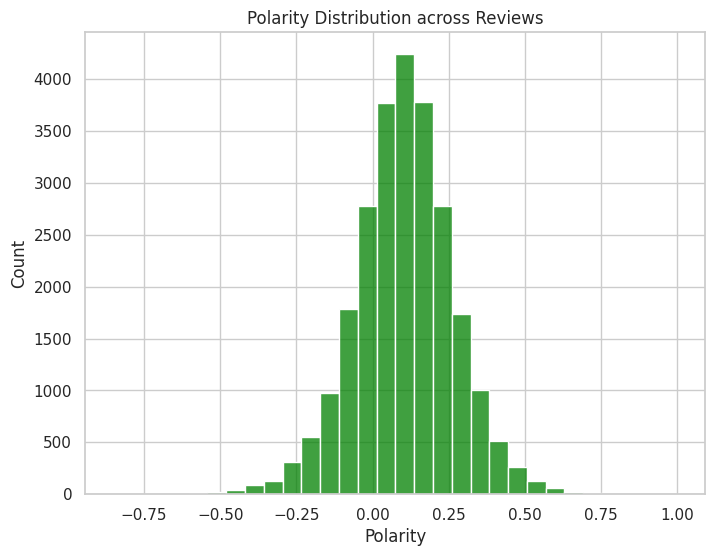

Number of label mismatches: 7871


In [ ]:
from textblob import TextBlob

# Function to get the polarity of reviews
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

train_data['Polarity'] = train_data['text'].apply(get_polarity)

# Plotting the polarity distribution
plt.figure(figsize=(8,6))
sns.histplot(train_data['Polarity'], bins=30, color='green')
plt.title('Polarity Distribution across Reviews')
plt.show()

# Checking mismatches between computed polarity and given labels
train_data['Computed Label'] = train_data['Polarity'].apply(lambda x: 'positive' if x > 0 else 'negative')
mismatches = train_data[train_data['Computed Label'] != train_data['label']]
print("Number of label mismatches:", mismatches.shape[0])


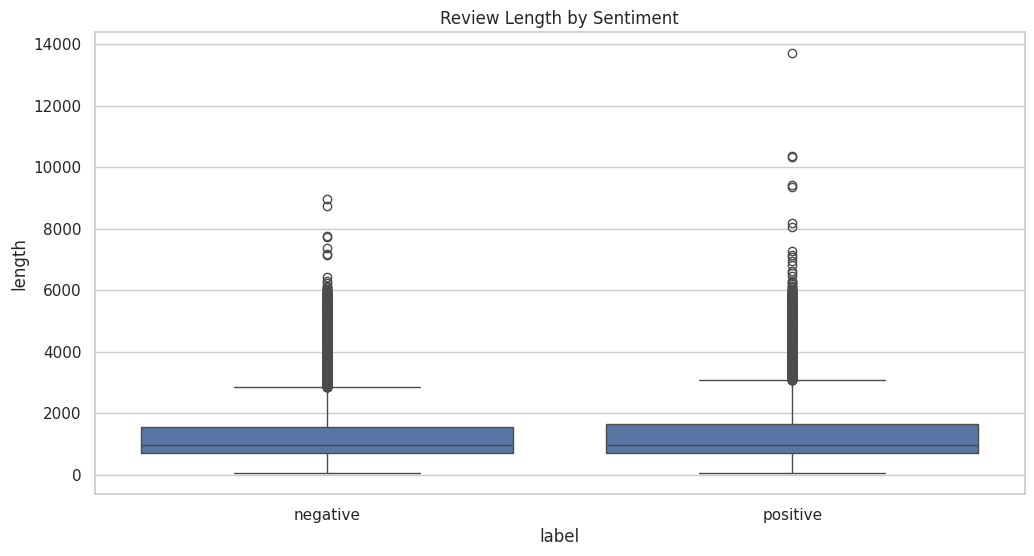

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='label', y='length', data=train_data)
plt.title('Review Length by Sentiment')
plt.show()


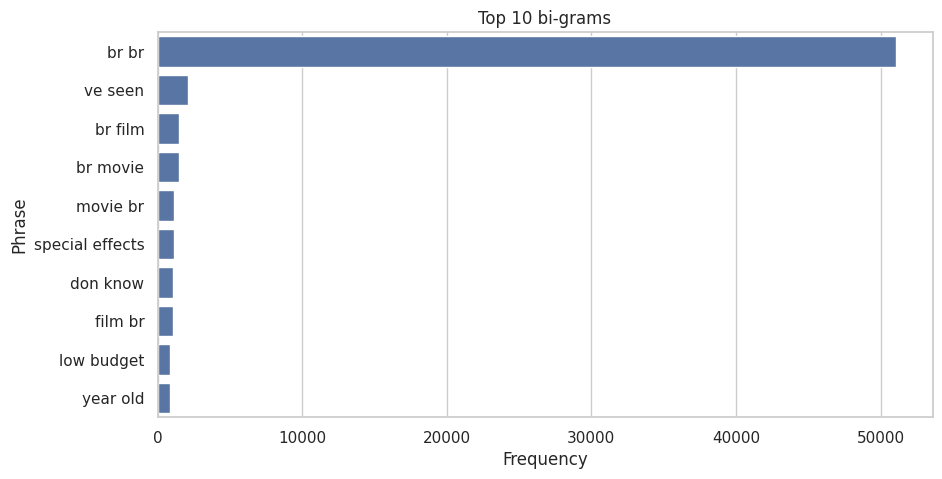

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, ngram_range=(2,2), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_items = words_freq[:top_n]
    top_df = pd.DataFrame(top_items, columns=['Phrase', 'Frequency'])
    plt.figure(figsize=(10,5))
    sns.barplot(x='Frequency', y='Phrase', data=top_df)
    plt.title('Top {} {}-grams'.format(top_n, 'bi' if ngram_range[1]==2 else 'tri'))
    plt.show()

plot_top_ngrams(train_data['text'], ngram_range=(2,2), top_n=10)


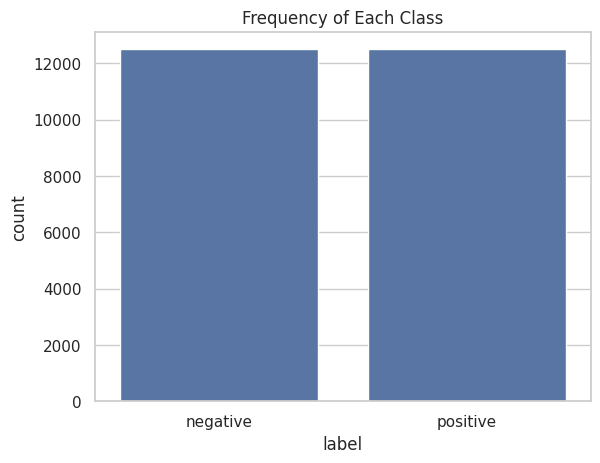

In [ ]:
# Checking the balance of classes
sns.countplot(x='label', data=train_data)
plt.title('Frequency of Each Class')
plt.show()


In [ ]:
# Checking for missing values
missing_values = train_data.isnull().sum()
print(missing_values)


label             0
text              0
length            0
Polarity          0
Computed Label    0
dtype: int64


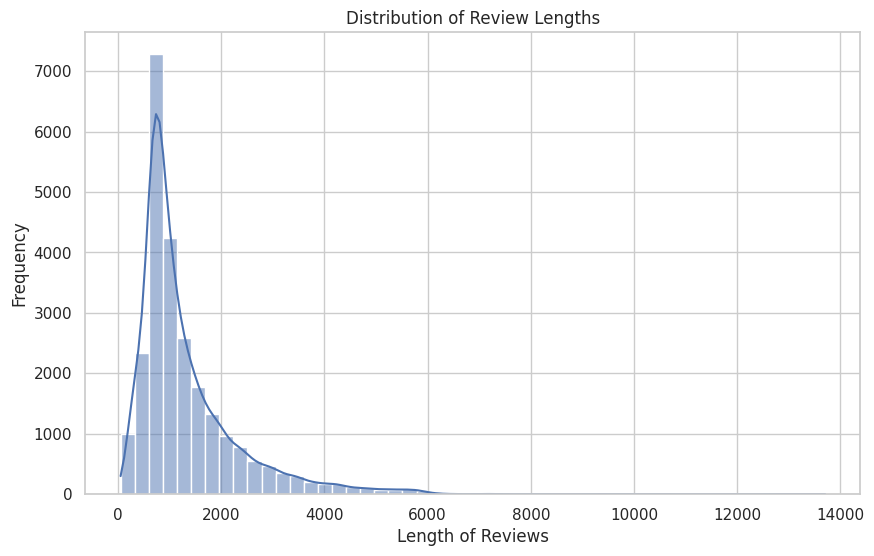

In [ ]:
# Plotting histogram of review lengths to detect outliers
plt.figure(figsize=(10, 6))
sns.histplot(train_data['length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Import the necessary modules at the beginning of your notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string  # This is the new import to define 'string'

# Assuming 'train_data' is already defined and contains the movie reviews
# Now let's add the corrected punctuation analysis:

# Calculating the count of punctuation marks in each review
train_data['punctuation_count'] = train_data['text'].apply(lambda x: sum([1 for char in x if char in string.punctuation]))

# Filtering to find reviews with a high count of punctuation marks
high_punctuation_texts = train_data[train_data['punctuation_count'] > 5]  # Using an arbitrary threshold of 5

# Displaying one sample review with high punctuation count
if not high_punctuation_texts.empty:
    print("Sample high punctuation text:", high_punctuation_texts.iloc[0]['text'])
else:
    print("No texts found with high punctuation count based on the current threshold.")


Sample high punctuation text: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.


In [ ]:
from textblob import TextBlob

# Heuristic check for possible labeling errors
def check_labeling(row):
    blob = TextBlob(row['text'])
    if blob.sentiment.polarity > 0 and row['label'] == 'negative':
        return 'Potential Error'
    elif blob.sentiment.polarity < 0 and row['label'] == 'positive':
        return 'Potential Error'
    else:
        return 'Okay'

# Applying the corrected function
train_data['label_check'] = train_data.apply(check_labeling, axis=1)
print(train_data[train_data['label_check'] == 'Potential Error'].head())



      label                                               text  length  \
2  negative  Mann photographs the Alberta Rocky Mountains i...     787   
6  negative  Okay, you have:<br /><br />Penelope Keith as M...    3277   
7  negative  The film is based on a genuine 1950s novel.<br...     663   
8  negative  I really love the sexy action and sci-fi films...    1220   
9  negative  Sure, this one isn't really a blockbuster, nor...     696   

   Polarity Computed Label  is_repetitive  punctuation_count      label_check  
2  0.428571       positive          False                 34  Potential Error  
6  0.160234       positive          False                278  Potential Error  
7  0.263247       positive          False                 42  Potential Error  
8  0.211328       positive          False                 38  Potential Error  
9  0.156000       positive          False                 27  Potential Error  


In [ ]:
# Detection of repetitive text
def repetitive_text_detector(text):
    words = text.split()
    word_counts = Counter(words)
    max_freq = max(word_counts.values())
    if max_freq/len(words) > 0.5:  # Arbitrary threshold to detect repetition
        return True
    return False

train_data['is_repetitive'] = train_data['text'].apply(repetitive_text_detector)
print("Number of repetitive texts:", train_data['is_repetitive'].sum())


Number of repetitive texts: 2


In [ ]:
# Searching for biased texts based on a specific keyword
# Replace "stereotype keyword" with actual keywords of interest
biased_texts = train_data[train_data['text'].str.contains("stereotype keyword", na=False)]

# Safely handling cases where no matching texts are found
if not biased_texts.empty:
    print("Sample biased text:", biased_texts.iloc[0]['text'])
else:
    print("No texts found with the specified stereotype keyword.")


No texts found with the specified stereotype keyword.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Preparing the dataset
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['label'], test_size=0.2, random_state=42)

# Vectorization of text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_vec)

# Evaluating the model
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]))

# Additional useful metrics
from sklearn.metrics import confusion_matrix, f1_score
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, pos_label='positive'))


              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      2576
    positive       0.86      0.89      0.88      2424

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

AUC-ROC: 0.9449476828505833
Confusion Matrix:
 [[2236  340]
 [ 270 2154]]
F1 Score: 0.8759658397722652


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

input_ids = tokenizer.encode('This movie is', return_tensors='pt')

# Using beam search to generate multiple output sequences
sample_outputs = model.generate(
    input_ids,
    pad_token_id=50256,
    max_length=100,
    num_return_sequences=5,
    num_beams=5  # Enable beam search with 5 beams
)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: This movie is about a group of people who are trying to find a way to survive in a world where there are no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws
1: This movie is about a group of people who are trying to find a way to survive in a world where there are no jobs, no jobs, and no jobs. It's about a group of people who are trying to find a way to survive in a world where there are no jobs, no jobs, and no jobs. It's about a group of people who are trying to find a way to survive in a world where there are no jobs, no jobs, and no jobs. It's about
2: This movie is about a group of people who are trying to find a way to survive in a world where there are no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no laws, no 

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

input_ids = tokenizer.encode('This movie is', return_tensors='pt')

# Using random sampling to generate multiple output sequences
sample_outputs = model.generate(
    input_ids,
    pad_token_id=50256,
    max_length=100,
    num_return_sequences=5,
    do_sample=True,  # Enable random sampling
    top_k=50  # Set top-k sampling
)

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: This movie is a real masterpiece of visual comedy, with a twist that, if that was possible, would be completely impossible for anyone to understand."

The film depicts the day of the Paris attacks, a day that is often portrayed as a disaster but isn't. The story unfolds after the first plane is forced into its cabin as bombs are dropped on the ground. It's there that the world is bombarded with terror.

The film is in theaters now.

© 2018 Cox
1: This movie is essentially a sequel to last year's hit series, 'The Legend of Korra', which is set in the fictional life of a young woman who travels back in time to the past to find that her brother has abandoned her. While the plot is rather simple at first, the ending leads into a whole series of bizarre events that you will follow as the series progresses, not to mention the fact that when our hero is killed in his attempt to save his beloved Avatar, he may have been left
2: This movie is an extremely emotional, emotionally affecting fil

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

text = "your review text goes here"
inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

print(tokenizer.decode(outputs[0]))


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<pad> your review text goes here. your review text goes here. click here to read our review text. review text: review text is a review text. review text is a review text.</s>


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

model_name = 'Helsinki-NLP/opus-mt-en-fr'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

text = "Replace this text with your review"
translated = model.generate(**tokenizer(text, return_tensors="pt", padding=True))

print([tokenizer.decode(t, skip_special_tokens=True) for t in translated])


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

['Remplacer ce texte par votre commentaire']
